# CAATEX ray trace

Solely contained in **Face 3** (face=2) of ASTE R1, the CAATEX basin scale experiment provided mode type arrival structures. Here, I am using the state estimate output of ASTE R1 to simulate ray traces along *assumed* source receiver locations. 

We know the Vertical Line Array (VLA) on the West end conatined 40 hydrophones with 25 m spacing, and the VLA on the East conatined 25 hydrophones with a 40 m spacing. The frequency was 35 Hz (called ultra-low frequency).

In [1]:
from importlib import reload
import sandbox as sb
import numpy as np
import xarray as xr
import xesmf as xe
import xmitgcm
import ecco_v4_py as ecco

import os
import warnings
warnings.simplefilter('ignore')
os.environ['PYTHONWARNOINGS'] = 'ignore'

import matplotlib.pyplot as plt
import cmocean.cm as cm

## Load ASTE R1
Saved `THETA`, `SALT`, and `SIarea` for the full year of 2016

ASTE R1 is based on the *llc270* horizontal grid which works out to a $1/3^\circ$ grid spacing

In [2]:
ds = xr.open_dataset('/Users/ivana/work/asteR1/aste_THETA-SALT-SIarea_2016.nc')
ds = ds.isel(face=2)
display(ds)

<xarray.Dataset>
Dimensions:    (i: 270, i_g: 270, j: 270, j_g: 270, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, time: 12)
Coordinates: (12/47)
    face       int64 2
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    maskInS    (j_g, i) float64 ...
    maskInW    (j, i_g) float64 ...
    maskS      (k, j_g, i) float64 ...
    maskW      (k, j, i_g) float64 ...
    Zl         (k_l) float64 ...
    Zu         (k_u) float64 ...
Data variables:
    THETA      (time, k, j, i) float32 ...
    SALT       (time, k, j, i) float32 ...
    SIarea     (time, j, i) float32 ...

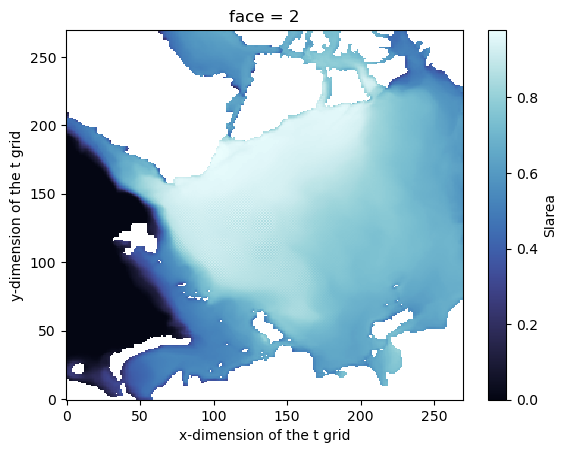

In [3]:
SIareamean = ds.SIarea.mean('time')
SIareamean.plot(cmap=cm.ice)

## Add sound speed to the dataset

Step 1: Get pressure in `dbars`, use depth values for each depth layer (`Z` in the xr.DataSet), and latitudes. 

Step 2: Calculate sound speed using the `seawater` package, need temperature in ITS-90 format, so first convert from potential temperature using a reference pressure of ???. 

In [4]:
import seawater as sw

In [5]:
karray = np.ones_like(ds.THETA.isel(time=0))
latarray = np.ones_like(karray)

Z = ds.Z.data
lats = ds.YC.data

for k in range(len(Z)):
    karray[k,:,:] = Z[k] * np.ones((270,270))
    latarray[k,:,:] = lats

In [6]:
ds['press'] = xr.DataArray(sw.eos80.pres(karray, latarray), 
                           coords={'k':ds.k, 
                                   'j':ds.j, 
                                   'i':ds.i},
                           dims=('k','j','i'),
                           attrs=dict(description='pressure',
                                      units='dbar')   )

# DO NOT USE potential temperature

In [7]:
cSound = np.ones_like(ds.THETA)

for t in range(len(ds.time)):
    cSound[t,:,:,:] = sw.eos80.svel(ds.SALT.isel(time=t),
                                         ds.THETA.isel(time=t),
                                         ds.press)

In [8]:
ds['cSound'] = xr.DataArray(cSound, 
                            coords={'time':ds.time,
                                    'k':ds.k, 
                                    'j':ds.j,
                                    'i':ds.i},
                            dims=('time','k','j','i'),
                            attrs=dict(description='sound velocity',
                                       units='m/s')   
                           )

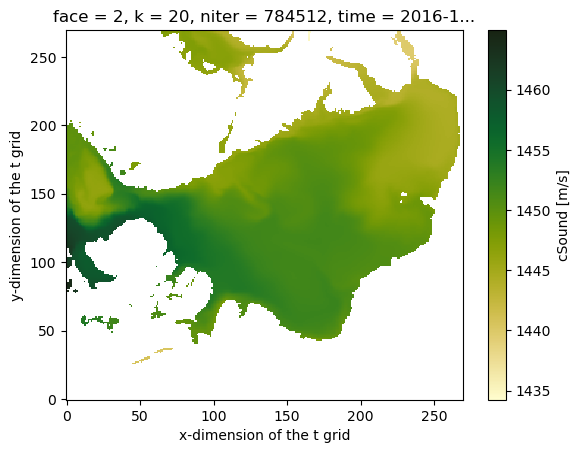

In [9]:
ds.cSound.isel(time=11,k=20).plot(cmap=cm.speed)

## Extract geodesic spacings between source and reciever positions

need to rename coordinates XC and YC to lon and lat

In [10]:
ds = ds.rename({'XC': 'lon', 'YC':'lat'})
ds = ds.drop_dims({'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'})

**Route 1** from SIO 1 to NERSC 2

In [11]:
r1 = sb.wgs84space([-150, 81], [27, 83], npts=256)

In [12]:
dsll = xr.Dataset(  {
                        "lat": (['lat'], r1.lats),
                        "lon": (['lon'], r1.lons),
                      })
regridder = xe.Regridder(ds, dsll, "bilinear")
dsr1 = regridder(ds)
regridder = xe.Regridder(ds.Depth, dsll, "bilinear")
daD = regridder(ds.Depth)

In [13]:
dsr1['Depth'] = daD
display(dsr1)

<xarray.Dataset>
Dimensions:  (time: 12, k: 50, lat: 256, lon: 256)
Coordinates:
    face     int64 2
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    niter    (time) int64 736272 740736 744912 749376 ... 775728 780192 784512
  * time     (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2016-12-01
    drF      (k) float64 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    PHrefC   (k) float64 49.05 147.2 245.2 ... 4.944e+04 5.357e+04 5.794e+04
    Z        (k) float64 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    rhoRef   (k) float64 1.024e+03 1.024e+03 1.024e+03 ... 1.052e+03 1.054e+03
  * lat      (lat) float64 81.0 81.06 81.13 81.19 ... 83.19 83.13 83.06 83.0
  * lon      (lon) float64 -150.0 -150.0 -150.0 -150.0 ... 26.97 26.98 27.0
Data variables:
    THETA    (time, k, lat, lon) float32 -1.601 -1.601 -1.601 ... nan nan nan
    SALT     (time, k, lat, lon) float32 29.41 29.41 29.41 29.41 ... nan nan nan
    SIarea   (time, lat, lon) float32 0.9974 0.9974 0.9974 ... 0.9019 0.9019
    press    (k, lat, lon) float32 -5.057 -5.057 ... -5.895e+03 -5.895e+03
    cSound   (time, k, lat, lon) float32 1.434e+03 1.434e+03 ... nan nan
    Depth    (lat, lon) float64 3.732e+03 3.732e+03 ... 3.975e+03 3.975e+03
Attributes:
    regrid_method:  bilinear

`dsr1` contains the path values along its diagonal, which can be accessed using commands such as: 

```
dsr1.cSound.mean('time').data.diagonal()
```

# Prepare input for ray trace

Populate bathymetric structure and sound speed profile from ASTE R1 to a ray trace run. Using `arlpy` 

## make a pandas DataFrame of range-dependent sound

ditionary with keys as ranges, and values of sound speed profiles for that given range. Then a list of the depths used to define the sound speed profiles.

In [34]:
import arlpy.uwapm as pm
from pandas import DataFrame

In [15]:
ranges = np.array( [i*r1.del_s for i in range(len(r1.lons))] )
depths = dsr1.Depth.data.diagonal()
sspData = dsr1.cSound.mean('time').data.diagonal(axis1=1,axis2=2)
sspData.setflags(write=1)

## Extend sound speed profiles 
#### at surface
**ihop** requires you start at 0 m in depth, and ASTE R1 starts at 5m depth. So we prepend a 0m depth layer

In [16]:
tmp = sw.eos80.svel(
    dsr1.SALT.mean( 'time').isel(k=0).data.diagonal(),
    dsr1.THETA.mean('time').isel(k=0).data.diagonal(),
    0.0            )
sspData = np.vstack((tmp[:, np.newaxis].T, sspData))

#### through seafloor
**ihop** requires the ssp field to be specified at all depths of the acoustic domain. We will hold THETA and SALT constant and vary pressure to extend sound speed in depth.

In [17]:
%%time
for r in range(len(ranges)):
    tmp = dsr1.THETA.mean('time').isel(lat=r,lon=r)
    firstnan = len(tmp.where(np.isnan(tmp) != True, drop=True)) + 1
    
    theta = tmp.isel(k=firstnan-2)
    salt  = dsr1.SALT.mean('time').isel(lat=r,lon=r,k=firstnan-2)
    for k in range(firstnan, len(dsr1.k)+1):
        sspData[k,r] = sw.eos80.svel( salt, theta,
                                    dsr1.press.isel(lat=r,lon=r,k=k-1) )

CPU times: user 38.1 s, sys: 516 ms, total: 38.7 s
Wall time: 38.7 s


#### Write sound speed into a pandas DataFrame

In [18]:
bathy = []
sspDict = {}

for i in range(len(ranges)):
    bathy.append( [ranges[i], depths[i]] )

    sspDict[ranges[i]] = list(sspData[:,i])

bathy.append( [ranges[-1]+r1.del_s*10, depths[-1]] )
sspDict[ranges[-1]+r1.del_s*10] = list(sspData[:,-1])

In [19]:
z = [0.0]+list(-1*dsr1.Z.data)
ssp = DataFrame( sspDict,
                index=z )

create environment

In [20]:
env = pm.create_env2d(
    name='caatex sio1-nersc2',
    frequency=35,
    
    tx_depth=60,
    
    rx_depth=60, # assumed by Escobar, I
    rx_range=ranges[-2],
    
    depth = bathy,
    depth_interp = 'linear',
    
    soundspeed=ssp,
    
    bottom_absorption=0.0,
    
    min_angle=-50,
    max_angle=50,
    #nbeams=600,
)

In [21]:
#pm.print_env(env)
#pm.plot_env(env, width=600)

In [22]:
#%%time
#rays = pm.compute_rays(env, debug=True)
#pm.plot_rays(rays, env=env, width=600)

In [23]:
east_rx = [60 + i*40 for i in range(25)]
env['rx_depth'] = np.array(east_rx)
#pm.print_env(env)

In [24]:
#%%time
#erays = pm.compute_eigenrays(env, rx_depth_ndx=0, debug=True)
#pm.plot_rays(erays, env=env, width=600)

In [25]:
#erays

In [26]:
env['min_angle']=-13
env['max_angle']=13
env['nbeams']=2600

In [27]:
#%%time
#erays = pm.compute_eigenrays(env, rx_depth_ndx=-1, debug=True)
#pm.plot_rays(erays, env=env, width=600)

In [28]:
%%time
env['nbeams'] = 260
erays = pm.compute_eigenrays(env, rx_depth_ndx=-1, debug=True)
#pm.plot_rays(erays, env=env, width=600)

[DEBUG] Model: bellhop
[DEBUG] Bellhop working files: /var/folders/nr/cn91kz512334w8_9vxjtjs8w0000gq/T/tmpjeq_izal.*
CPU times: user 5.81 s, sys: 139 ms, total: 5.95 s
Wall time: 1min


In [33]:
erays

,angle_of_departure,surface_bounces,bottom_bounces,ray
0,-12.498069,60,78,"[[0.0, 60.0], [0.057662898614827617, 59.987218..."
0,-11.895753,63,83,"[[0.0, 60.0], [0.05779407523426732, 59.9878252..."
0,-10.490347,64,86,"[[0.0, 60.0], [0.058075292718659896, 59.989246..."
0,-10.389961,78,88,"[[0.0, 60.0], [0.05809404455365766, 59.9893481..."
0,-10.289575,74,85,"[[0.0, 60.0], [0.058112618055077496, 59.989449..."
...,...,...,...,...
0,10.590734,63,87,"[[0.0, 60.0], [0.058056388250268834, 60.010855..."
0,11.795367,61,82,"[[0.0, 60.0], [0.05781534584807413, 60.0120733..."
0,11.895753,62,83,"[[0.0, 60.0], [0.05779410386372319, 60.0121745..."
0,12.196911,75,88,"[[0.0, 60.0], [0.05772931369570663, 60.0124781..."


In [36]:
arr = pm.compute_arrivals(env, debug=True)
#pm.plot_arrivals(arr, dB=True)

[DEBUG] Model: bellhop
[DEBUG] Bellhop working files: /var/folders/nr/cn91kz512334w8_9vxjtjs8w0000gq/T/tmpz73ahwwo.*


<sub> Written by Escobar, I on April 2023 </sub>